# Libraries

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import numpy as np

# Read data

In [6]:
work_dir='/home/ggomarr/Documents/Education/20170623 Udemy - Machine Learning A-Z: Hands-On Python and R in Data Science/' + \
         'Course data/Part 6 - Reinforcement Learning/Section 33 - Thompson Sampling/'
df=pd.read_csv(work_dir+'Ads_CTR_Optimisation.csv')
df.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [7]:
df.mean()

Ad 1     0.1703
Ad 2     0.1295
Ad 3     0.0728
Ad 4     0.1196
Ad 5     0.2695
Ad 6     0.0126
Ad 7     0.1112
Ad 8     0.2091
Ad 9     0.0952
Ad 10    0.0489
dtype: float64

# Thomson Sampling

In [30]:
class ThomSamp():
    def __init__(self,
                 sim_stream_file,separator=',',header=True,
                 randomize_stream=False,
                 seed_rounds=1,randomize_seed=False,
                 use_probs=False,
                 random_seed=None):
        self.sim_stream_file=sim_stream_file
        with open(self.sim_stream_file,'r') as sim_stream:
            self.sim_stream=[ [int(out) for out in sim_event.strip().split(separator)]
                              for sim_event in sim_stream.readlines()[header:] ]
        self.num_bandits=len(self.sim_stream[0])
        self.randomize_stream=randomize_stream
        self.randomize_seed=randomize_seed
        self.use_probs=use_probs
        self.o=[0]*self.num_bandits
        self.z=[0]*self.num_bandits
        self.a=[0]*self.num_bandits
        self.p=[0]*self.num_bandits
        np.random.seed(random_seed)
        for seed_round in range(seed_rounds):
            self.seed()
    def seed(self):
        seed_pos_lst=list(range(self.num_bandits))
        if self.randomize_seed:
            np.random.shuffle(seed_pos_lst)
        print('Seeding {}...'.format(seed_pos_lst))
        for pos in seed_pos_lst:
            self.show(pos)
        self.compute()
        self.report()
    def show(self,pos):
        if self.randomize_stream:
            record_pos=np.random.randint(0,len(self.sim_stream))
        else:
            record_pos=sum(self.o)+sum(self.z)
        if self.sim_stream[record_pos][pos]==1:
            self.o[pos]=self.o[pos]+1
        else:
            self.z[pos]=self.z[pos]+1
    def compute(self):
        probs=[ np.random.beta(self.o[pos]+1,self.z[pos]+1) for pos in range(self.num_bandits) ]
        self.p=[ prob/sum(probs) for prob in probs ]
        self.a=[ 1.0*self.o[pos]/(self.o[pos]+self.z[pos]) for pos in range(self.num_bandits) ]
    def report(self):
        print('=== State at round {} ==='.format(sum(self.o)+sum(self.z)))
        print('Total score: {}'.format(sum(self.o)))
        for pos in range(self.num_bandits):
            print('Bandit {:d}: seen {:4d}, score {:4d}, '.format(pos,self.o[pos]+self.z[pos],self.o[pos]) + \
                  'average {:.2f}, prob {:.2f}'.format(self.a[pos],self.p[pos]))
    def stream_it_to_me(self,num_rounds=100):
        for r in range(num_rounds):
            if self.use_probs:
                pos=np.random.choice(range(self.num_bandits),p=self.p)
            else:
                pos=np.argmax(self.p)
            self.show(pos)
            self.compute()
        self.report()

In [31]:
thomsam=ThomSamp(work_dir+'Ads_CTR_Optimisation.csv',
                 seed_rounds=1,randomize_seed=False,
                 randomize_stream=False,use_probs=False)

Seeding [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
=== State at round 10 ===
Total score: 1
Bandit 0: seen    1, score    1, average 1.00, prob 0.13
Bandit 1: seen    1, score    0, average 0.00, prob 0.00
Bandit 2: seen    1, score    0, average 0.00, prob 0.01
Bandit 3: seen    1, score    0, average 0.00, prob 0.19
Bandit 4: seen    1, score    0, average 0.00, prob 0.15
Bandit 5: seen    1, score    0, average 0.00, prob 0.04
Bandit 6: seen    1, score    0, average 0.00, prob 0.12
Bandit 7: seen    1, score    0, average 0.00, prob 0.07
Bandit 8: seen    1, score    0, average 0.00, prob 0.17
Bandit 9: seen    1, score    0, average 0.00, prob 0.13


In [32]:
thomsam.stream_it_to_me(9990)

=== State at round 10000 ===
Total score: 2608
Bandit 0: seen   71, score    8, average 0.11, prob 0.18
Bandit 1: seen   84, score   11, average 0.13, prob 0.11
Bandit 2: seen   67, score    7, average 0.10, prob 0.16
Bandit 3: seen   63, score    6, average 0.10, prob 0.13
Bandit 4: seen 9526, score 2566, average 0.27, prob 0.23
Bandit 5: seen   28, score    0, average 0.00, prob 0.07
Bandit 6: seen   53, score    5, average 0.09, prob 0.08
Bandit 7: seen   56, score    5, average 0.09, prob 0.03
Bandit 8: seen   27, score    0, average 0.00, prob 0.01
Bandit 9: seen   25, score    0, average 0.00, prob 0.00


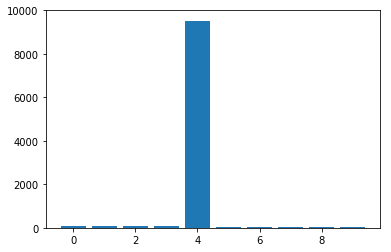

In [33]:
plt.bar(range(thomsam.num_bandits),[thomsam.o[pos]+thomsam.z[pos] for pos in range(thomsam.num_bandits)])
plt.show()

In [34]:
thomsam=ThomSamp(work_dir+'Ads_CTR_Optimisation.csv',
                 seed_rounds=1,randomize_seed=True,
                 randomize_stream=False,use_probs=False)

Seeding [1, 0, 6, 9, 4, 8, 7, 2, 3, 5]...
=== State at round 10 ===
Total score: 0
Bandit 0: seen    1, score    0, average 0.00, prob 0.01
Bandit 1: seen    1, score    0, average 0.00, prob 0.18
Bandit 2: seen    1, score    0, average 0.00, prob 0.05
Bandit 3: seen    1, score    0, average 0.00, prob 0.02
Bandit 4: seen    1, score    0, average 0.00, prob 0.08
Bandit 5: seen    1, score    0, average 0.00, prob 0.07
Bandit 6: seen    1, score    0, average 0.00, prob 0.25
Bandit 7: seen    1, score    0, average 0.00, prob 0.15
Bandit 8: seen    1, score    0, average 0.00, prob 0.06
Bandit 9: seen    1, score    0, average 0.00, prob 0.13


In [35]:
thomsam.stream_it_to_me(9990)

=== State at round 10000 ===
Total score: 2599
Bandit 0: seen   39, score    2, average 0.05, prob 0.05
Bandit 1: seen   85, score   11, average 0.13, prob 0.06
Bandit 2: seen   61, score    6, average 0.10, prob 0.10
Bandit 3: seen  131, score   22, average 0.17, prob 0.16
Bandit 4: seen 9268, score 2503, average 0.27, prob 0.22
Bandit 5: seen   23, score    0, average 0.00, prob 0.06
Bandit 6: seen   69, score    7, average 0.10, prob 0.08
Bandit 7: seen  222, score   40, average 0.18, prob 0.14
Bandit 8: seen   74, score    8, average 0.11, prob 0.10
Bandit 9: seen   28, score    0, average 0.00, prob 0.02


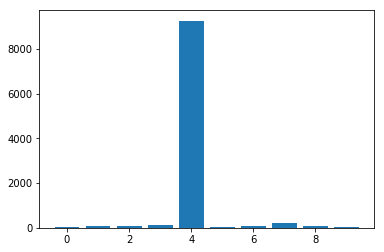

In [36]:
plt.bar(range(thomsam.num_bandits),[thomsam.o[pos]+thomsam.z[pos] for pos in range(thomsam.num_bandits)])
plt.show()

In [37]:
thomsam=ThomSamp(work_dir+'Ads_CTR_Optimisation.csv',
                 seed_rounds=1,randomize_seed=True,
                 randomize_stream=True,use_probs=False)

Seeding [9, 6, 4, 1, 5, 8, 2, 7, 3, 0]...
=== State at round 10 ===
Total score: 0
Bandit 0: seen    1, score    0, average 0.00, prob 0.11
Bandit 1: seen    1, score    0, average 0.00, prob 0.14
Bandit 2: seen    1, score    0, average 0.00, prob 0.10
Bandit 3: seen    1, score    0, average 0.00, prob 0.03
Bandit 4: seen    1, score    0, average 0.00, prob 0.25
Bandit 5: seen    1, score    0, average 0.00, prob 0.10
Bandit 6: seen    1, score    0, average 0.00, prob 0.02
Bandit 7: seen    1, score    0, average 0.00, prob 0.06
Bandit 8: seen    1, score    0, average 0.00, prob 0.03
Bandit 9: seen    1, score    0, average 0.00, prob 0.16


In [38]:
thomsam.stream_it_to_me(9990)

=== State at round 10000 ===
Total score: 2536
Bandit 0: seen   48, score    5, average 0.10, prob 0.13
Bandit 1: seen   60, score    5, average 0.08, prob 0.11
Bandit 2: seen   25, score    0, average 0.00, prob 0.02
Bandit 3: seen   59, score    5, average 0.08, prob 0.10
Bandit 4: seen 9193, score 2417, average 0.26, prob 0.22
Bandit 5: seen   26, score    0, average 0.00, prob 0.00
Bandit 6: seen   53, score    4, average 0.08, prob 0.10
Bandit 7: seen  469, score   98, average 0.21, prob 0.20
Bandit 8: seen   41, score    2, average 0.05, prob 0.08
Bandit 9: seen   26, score    0, average 0.00, prob 0.03


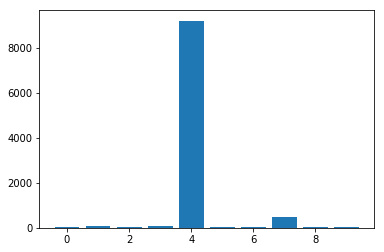

In [39]:
plt.bar(range(thomsam.num_bandits),[thomsam.o[pos]+thomsam.z[pos] for pos in range(thomsam.num_bandits)])
plt.show()

In [43]:
thomsam=ThomSamp(work_dir+'Ads_CTR_Optimisation.csv',
                 seed_rounds=1,randomize_seed=True,
                 randomize_stream=True,use_probs=True)

Seeding [7, 2, 9, 6, 5, 8, 3, 4, 1, 0]...
=== State at round 10 ===
Total score: 0
Bandit 0: seen    1, score    0, average 0.00, prob 0.10
Bandit 1: seen    1, score    0, average 0.00, prob 0.24
Bandit 2: seen    1, score    0, average 0.00, prob 0.12
Bandit 3: seen    1, score    0, average 0.00, prob 0.10
Bandit 4: seen    1, score    0, average 0.00, prob 0.02
Bandit 5: seen    1, score    0, average 0.00, prob 0.03
Bandit 6: seen    1, score    0, average 0.00, prob 0.00
Bandit 7: seen    1, score    0, average 0.00, prob 0.15
Bandit 8: seen    1, score    0, average 0.00, prob 0.14
Bandit 9: seen    1, score    0, average 0.00, prob 0.10


In [44]:
thomsam.stream_it_to_me(9990)

=== State at round 10000 ===
Total score: 1663
Bandit 0: seen 1213, score  209, average 0.17, prob 0.14
Bandit 1: seen  970, score  124, average 0.13, prob 0.10
Bandit 2: seen  836, score   75, average 0.09, prob 0.07
Bandit 3: seen  992, score  121, average 0.12, prob 0.10
Bandit 4: seen 2081, score  552, average 0.27, prob 0.23
Bandit 5: seen  119, score    0, average 0.00, prob 0.00
Bandit 6: seen  994, score  118, average 0.12, prob 0.09
Bandit 7: seen 1782, score  401, average 0.23, prob 0.17
Bandit 8: seen  430, score   27, average 0.06, prob 0.04
Bandit 9: seen  583, score   36, average 0.06, prob 0.06


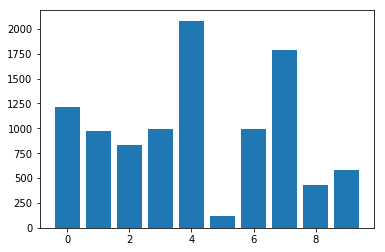

In [45]:
plt.bar(range(thomsam.num_bandits),[thomsam.o[pos]+thomsam.z[pos] for pos in range(thomsam.num_bandits)])
plt.show()